In [81]:
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
import copy
import numpy as np
import torch
from unidepth.utils import colorize, image_grid
from unidepth.models import UniDepthV1
from unidepth.utils.visualization import colorize_np
from unidepth.utils.geometric import project_points
from PIL import Image
import open3d as o3d
import cv2
import fuse_depth as fd
import os
import random
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
model = UniDepthV1.from_pretrained("lpiccinelli/unidepth-v1-vitl14")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

support_paths = []

depth_paths = sorted(os.listdir('../data/environment1/depths'))
image_paths = sorted(os.listdir('../data/environment1/images'))

min_mse = []
median_mse = []
mean_mse = []
unidepth_mse = []

min_05 = []
median_05 = []
mean_05 = []
unidepth_05 = []

min_1 = []
median_1 = []
mean_1 = []
unidepth_1 = []

min_2 = []
median_2 = []
mean_2 = []
unidepth_2 = []

for i in range(1):
    if radius <= 0 or radius >= len(depth_paths):
        radius = len(depth_paths)

    base_ind = 50
    selects = [20,80]
    
    base_path = f'../data/environment1/images/image_{int(base_ind)}.png'
    support_paths = [f'../data/environment1/images/image_{int(x)}.png' for x in selects]

    H,W  = np.array(Image.open(base_path)).shape[:2]

    sup_pcds = []
    for i, sup_path in enumerate(support_paths):
        T, scale, torch_intrinsics1, torch_points1, torch_depth_output = fd.pairwise_pose(base_path, sup_path, model) # base, sup order
        """ if scale > 1.2 or scale < 0.9:
            continue """
        pcd1 = o3d.io.read_point_cloud("ply2/im1.ply")
        pcd2 = o3d.io.read_point_cloud("ply2/im2.ply")
        pcd2 = pcd2.scale(scale, center=(0, 0, 0))
        pcd2 = pcd2.transform(T)
        o3d.io.write_point_cloud(f"ply2/{i}.ply", pcd2)
        sup_pcds.append(pcd2)

    print(support_paths)
    print(base_path)

    pcd_comb = copy.deepcopy(pcd1)
    for pcd in sup_pcds:
        #T = fd.icp(pcd, pcd1)
        dup_pcd = copy.deepcopy(pcd) 
        #dup_pcd.transform(T)
        pcd_comb += dup_pcd

    o3d.io.write_point_cloud("ply2/merged.ply", pcd_comb)

    depth_min = fd.create_depth_map(np.asarray(pcd_comb.points), torch_intrinsics1.squeeze().cpu().numpy(), (H,W), 'min')
    depth_min = cv2.medianBlur(depth_min.astype('float32'), 5)

    depth_col_avg = colorize_np(depth_min, vmin=0.01, vmax=10.0, cmap="magma_r")
    Image.fromarray(depth_col_avg).save("outputs/min.png")

    depth_median = fd.create_depth_map(np.asarray(pcd_comb.points), torch_intrinsics1.squeeze().cpu().numpy(), (H,W), 'median')
    depth_median = cv2.medianBlur(depth_median.astype('float32'), 5)

    depth_col_median = colorize_np(depth_median, vmin=0.01, vmax=10.0, cmap="magma_r")
    Image.fromarray(depth_col_avg).save("outputs/median.png")

    points_tensor = torch.tensor(np.asarray(pcd_comb.points), dtype=torch.float)
    points_tensor = points_tensor.view(-1, 3).unsqueeze(0).cuda()
    torch_depth_mean = project_points(points_tensor, torch_intrinsics1, (H,W))
    depth_pred_col_mean = colorize(torch_depth_mean.squeeze().cpu().numpy(), vmin=0.01, vmax=10.0, cmap="magma_r")
    Image.fromarray(depth_pred_col_mean).save("outputs/mean.png")

    depth_pred_col = colorize(torch_depth_output, vmin=0.01, vmax=10.0, cmap="magma_r")
    Image.fromarray(depth_pred_col).save("outputs/original.png") 

    gt = np.load(f"../data/environment1/depths/depth_{int(base_ind)}.npy")
    gt_col = colorize_np(gt, vmin=0.01, vmax=10.0, cmap="magma_r")
    Image.fromarray(gt_col).save("outputs/gt.png")

    og_depth = torch_depth_output
    mean_depth = torch_depth_mean.squeeze().cpu().numpy()
    valid_indices = ~np.isnan(gt)

    squared_error = (depth_min[valid_indices] - gt[valid_indices])**2
    mse = np.mean(squared_error)
    print("Min Reconstructed Depth MSE:", mse)
    min_mse.append(mse)

    squared_error = (depth_median[valid_indices] - gt[valid_indices])**2
    mse = np.mean(squared_error)
    print("Median Reconstructed Depth MSE:", mse)
    median_mse.append(mse)

    squared_error = (mean_depth[valid_indices] - gt[valid_indices])**2
    mse = np.mean(squared_error)
    print("Mean Reconstructed Depth MSE:", mse)
    mean_mse.append(mse)

    squared_error = (og_depth[valid_indices] - gt[valid_indices])**2
    mse = np.mean(squared_error)
    print("Original Depth MSE:", mse)
    unidepth_mse.append(mse)

    print("Tolerance: 0.5")
    print("Min Reconstructed Depth Percent:", fd.percent_within_tolerance(depth_min, gt, 0.5, valid_indices))
    print("Median Reconstructed Depth Percent:", fd.percent_within_tolerance(depth_median, gt, 0.5, valid_indices))
    print("Mean Reconstructed Depth Percent:",fd. percent_within_tolerance(mean_depth, gt, 0.5, valid_indices))
    print("Original Depth Percent:", fd.percent_within_tolerance(og_depth, gt, 0.5, valid_indices))
    min_05.append(fd.percent_within_tolerance(depth_min, gt, 0.5, valid_indices))
    median_05.append(fd.percent_within_tolerance(depth_median, gt, 0.5, valid_indices))
    mean_05.append(fd.percent_within_tolerance(mean_depth, gt, 0.5, valid_indices))
    unidepth_05.append(fd.percent_within_tolerance(og_depth, gt, 0.5, valid_indices))

    print("Tolerance: 1")
    print("Min Reconstructed Depth Percent:", fd.percent_within_tolerance(depth_min, gt, 1, valid_indices))
    print("Median Reconstructed Depth Percent:", fd.percent_within_tolerance(depth_median, gt, 1, valid_indices))
    print("Mean Reconstructed Depth Percent:", fd.percent_within_tolerance(mean_depth, gt, 1, valid_indices))
    print("Original Depth Percent:", fd.percent_within_tolerance(og_depth, gt, 1, valid_indices))
    min_1.append(fd.percent_within_tolerance(depth_min, gt, 1, valid_indices))
    median_1.append(fd.percent_within_tolerance(depth_median, gt, 1, valid_indices))
    mean_1.append(fd.percent_within_tolerance(mean_depth, gt, 1, valid_indices))
    unidepth_1.append(fd.percent_within_tolerance(og_depth, gt, 1, valid_indices))

    print("Tolerance: 2")
    print("Min Reconstructed Depth Percent:", fd.percent_within_tolerance(depth_min, gt, 2, valid_indices))
    print("Median Reconstructed Depth Percent:", fd.percent_within_tolerance(depth_median, gt, 2, valid_indices))
    print("Mean Reconstructed Depth Percent:", fd.percent_within_tolerance(mean_depth, gt, 2, valid_indices))
    print("Original Depth Percent:", fd.percent_within_tolerance(og_depth, gt, 2, valid_indices))

    min_2.append(fd.percent_within_tolerance(depth_min, gt, 2, valid_indices))
    median_2.append(fd.percent_within_tolerance(depth_median, gt, 2, valid_indices))
    mean_2.append(fd.percent_within_tolerance(mean_depth, gt, 2, valid_indices))
    unidepth_2.append(fd.percent_within_tolerance(og_depth, gt, 2, valid_indices))

Instantiate: dinov2_vitl14
1.2143091030975917
0.9547047345903924
['../data/environment1/images/image_20.png', '../data/environment1/images/image_80.png']
../data/environment1/images/image_50.png
Min Reconstructed Depth MSE: 16.853998
Median Reconstructed Depth MSE: 21.053984
Mean Reconstructed Depth MSE: 20.67054
Original Depth MSE: 21.47018
Tolerance: 0.5
Min Reconstructed Depth Percent: 10.39559703416684
Median Reconstructed Depth Percent: 8.163752159674981
Mean Reconstructed Depth Percent: 3.8697038263296006
Original Depth Percent: 0.013976139356567458
Tolerance: 1
Min Reconstructed Depth Percent: 21.87169422134831
Median Reconstructed Depth Percent: 18.964175299342397
Mean Reconstructed Depth Percent: 16.648232620791195
Original Depth Percent: 6.157453258247729
Tolerance: 2
Min Reconstructed Depth Percent: 50.11072475921281
Median Reconstructed Depth Percent: 45.518358140980695
Mean Reconstructed Depth Percent: 45.123411720197694
Original Depth Percent: 33.523938958006525


In [83]:
print("MSE Means")
print(np.mean(min_mse))
print(np.mean(median_mse))
print(np.mean(mean_mse))
print(np.mean(unidepth_mse))

""" print("MSE STD")
print(np.std(min_mse))
print(np.std(median_mse))
print(np.std(mean_mse))
print(np.std(unidepth_mse)) """

print("d_05 Means")
print(np.mean(min_05))
print(np.mean(median_05))
print(np.mean(mean_05))
print(np.mean(unidepth_05))

""" print("d_05 STD")
print(np.std(min_05))
print(np.std(median_05))
print(np.std(mean_05))
print(np.std(unidepth_05)) """

print("d_1 Means")
print(np.mean(min_1))
print(np.mean(median_1))
print(np.mean(mean_1))
print(np.mean(unidepth_1))

""" print("d_1 STD")
print(np.std(min_1))
print(np.std(median_1))
print(np.std(mean_1))
print(np.std(unidepth_1))
 """
print("d_2 Means")
print(np.mean(min_2))
print(np.mean(median_2))
print(np.mean(mean_2))
print(np.mean(unidepth_2))

""" print("d_2 STD")
print(np.std(min_2))
print(np.std(median_2))
print(np.std(mean_2))
print(np.std(unidepth_2)) """


MSE Means
16.853998
21.053984
20.67054
21.47018
d_05 Means
10.39559703416684
8.163752159674981
3.8697038263296006
0.013976139356567458
d_1 Means
21.87169422134831
18.964175299342397
16.648232620791195
6.157453258247729
d_2 Means
50.11072475921281
45.518358140980695
45.123411720197694
33.523938958006525


' print("d_2 STD")\nprint(np.std(min_2))\nprint(np.std(median_2))\nprint(np.std(mean_2))\nprint(np.std(unidepth_2)) '

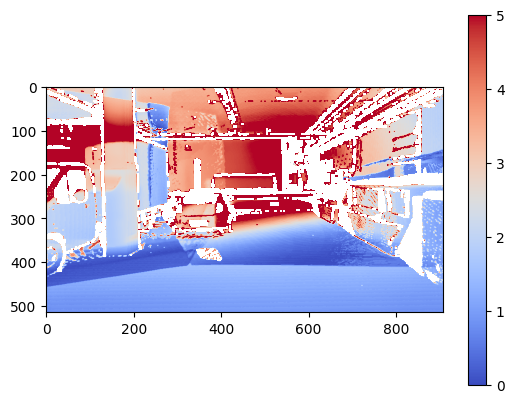

In [85]:
err = np.abs(depth_median - gt)
plt.imshow(err, vmin=0, vmax=5, cmap='coolwarm')
plt.colorbar()
plt.savefig('outputs/median_err.png')

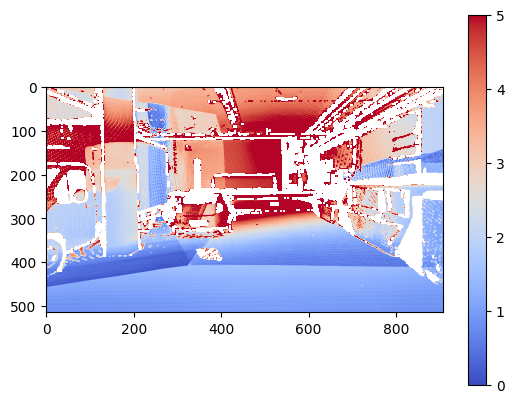

In [86]:
err = np.abs(mean_depth - gt)
plt.imshow(err, vmin=0, vmax=5, cmap='coolwarm')
plt.colorbar()
plt.savefig('outputs/mean_err.png')

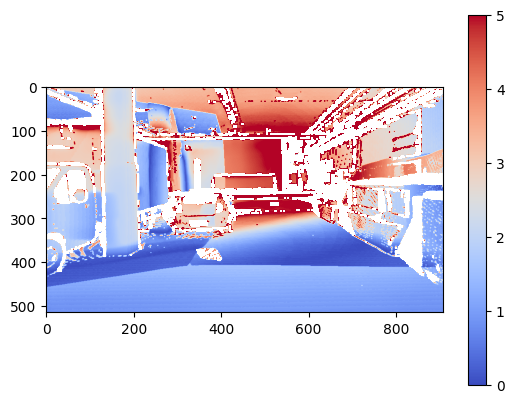

In [87]:
err = np.abs(depth_min - gt)
plt.imshow(err, vmin=0, vmax=5, cmap='coolwarm')
plt.colorbar()
plt.savefig('outputs/min_err.png')


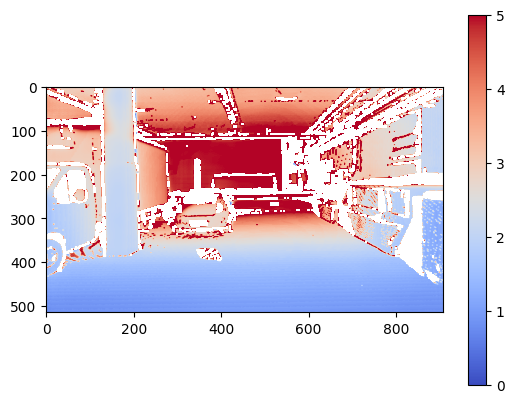

In [88]:
err = np.abs(og_depth - gt)
plt.imshow(err, vmin=0, vmax=5, cmap='coolwarm')
plt.colorbar()
plt.savefig('outputs/unidepth_err.png')